In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv
/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


 **your task is to predict whether a customer continues with their account or closes it (e.g., churns)**

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

In [4]:
dtrain = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
original = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')

In [5]:
train = pd.concat((dtrain, original), axis=0).drop(['RowNumber'], axis=1).drop_duplicates().dropna()

In [6]:
train.shape

(165034, 14)

In [7]:
print("train :", train.shape)
print("test :", test.shape)
train.head()

train : (165034, 14)
test : (110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1.0,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2.0,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3.0,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4.0,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [8]:
train.duplicated().sum()

0

In [9]:
# Création d'un tableau de visualisation des valeurs manquantes par colonnes
val_maq = train.isnull().sum().sort_values(ascending = False)
val_maq_percent = (train.isnull().sum()*100/len(train)).sort_values(ascending = False)
d = {'valeurs manquantes':val_maq, '% de valeurs manquantes':val_maq_percent}
df_miss_value = pd.DataFrame(d)
df_miss_value

,valeurs manquantes,% de valeurs manquantes
id,0,0.0
CustomerId,0,0.0
Surname,0,0.0
CreditScore,0,0.0
Geography,0,0.0
Gender,0,0.0
Age,0,0.0
Tenure,0,0.0
Balance,0,0.0
NumOfProducts,0,0.0


In [10]:
# Création d'un tableau de visualisation des valeurs manquantes par colonnes
val_maq = test.isnull().sum().sort_values(ascending = False)
val_maq_percent = (test.isnull().sum()*100/len(test)).sort_values(ascending = False)
d = {'valeurs manquantes':val_maq, '% de valeurs manquantes':val_maq_percent}
df_miss_value = pd.DataFrame(d)
df_miss_value

,valeurs manquantes,% de valeurs manquantes
id,0,0.0
CustomerId,0,0.0
Surname,0,0.0
CreditScore,0,0.0
Geography,0,0.0
Gender,0,0.0
Age,0,0.0
Tenure,0,0.0
Balance,0,0.0
NumOfProducts,0,0.0


In [11]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [12]:
train.nunique()

id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64

In [13]:
 train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  float64
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 18.9+ MB


In [14]:
#train = train.drop(['id','CustomerId','Surname'], axis=1)
train = train.drop(['id','CustomerId'], axis=1)

print('train')
print(train.duplicated().sum())
train.drop_duplicates(inplace=True)
print(train.duplicated().sum())
print('test')
print(test.duplicated().sum())
test.drop_duplicates(inplace=True)
print(test.duplicated().sum())

In [15]:
train.shape

(165034, 12)

In [16]:
train.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [17]:
cat_features =  ['Geography','Gender']
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

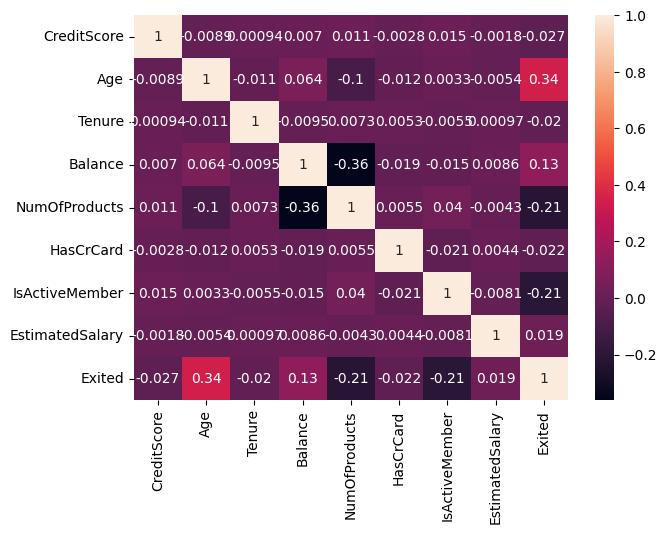

In [18]:
# Calculate correlation between each pair of variable
corr_matrix=train[num_features].corr()
# plot it
plt.figure(figsize = (7,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

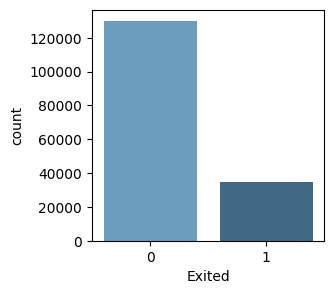

In [19]:
plt.figure(figsize=(3,3))
sns.countplot(data = train, x = "Exited", palette="Blues_d")
plt.show()

In [20]:
train.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import gc


# we return same text, because here we dont do any tokenization because surnames are usually not sentences and regular english language
def dummy(text):
    return text

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
    tokenizer = dummy,
    preprocessor = dummy,
    token_pattern = None, 
    strip_accents='unicode',
    max_features=1000
)

vectorizer.fit(train["Surname"])

vocab = vectorizer.vocabulary_

vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
                            analyzer = 'word',
                            tokenizer = dummy,
                            preprocessor = dummy,
                            token_pattern = None, strip_accents='unicode', max_features=1000
                            )


train_surnames = vectorizer.fit_transform(train["Surname"])
test_surnames = vectorizer.transform(test["Surname"])
gc.collect()

13955

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
tfidf_train_pca = pca.fit_transform(train_surnames.toarray())
tfidf_test_pca = pca.transform(test_surnames.toarray())

pca_columns = [f'Surname_PCA_{i+1}' for i in range(10)]
df_train_pca = pd.DataFrame(tfidf_train_pca, columns=pca_columns)
df_test_pca = pd.DataFrame(tfidf_test_pca, columns=pca_columns)

In [23]:
train.reset_index(drop=True, inplace=True)
df_train_pca.reset_index(drop=True, inplace=True)

train = pd.concat([train, df_train_pca], axis="columns")

In [24]:
test.reset_index(drop=True, inplace=True)
df_test_pca.reset_index(drop=True, inplace=True)

test = pd.concat([test, df_test_pca], axis="columns")

In [25]:
train = train.drop("Surname", axis=1)
test  = test.drop("Surname", axis=1)

In [26]:
train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_PCA_1,Surname_PCA_2,Surname_PCA_3,Surname_PCA_4,Surname_PCA_5,Surname_PCA_6,Surname_PCA_7,Surname_PCA_8,Surname_PCA_9,Surname_PCA_10
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,...,0.422164,0.078779,0.056111,0.006506,0.007160,0.004225,0.017867,-0.005460,0.015325,0.006431
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,...,0.106374,0.008228,-0.005448,-0.002259,-0.020683,-0.026041,0.058038,-0.022968,0.019080,0.002391
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,...,-0.034268,-0.028503,-0.041873,-0.014015,-0.026880,-0.026632,-0.020685,0.022441,-0.048029,-0.014137
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,...,-0.034515,-0.030006,-0.046696,-0.010891,-0.051566,-0.064367,-0.033203,0.036552,-0.067024,-0.010241
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,...,-0.025973,-0.033261,-0.029081,-0.015881,-0.043469,-0.038619,-0.045419,0.014975,-0.095308,-0.123515


In [27]:
X = train.drop('Exited', axis = 1)
y = train.Exited

In [28]:
# recherche des meilleurs paramètres

param_grid = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(1000, 2000),
}

# Paramètres pour la recherche par grille

seed = 42
splits = 3
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)

# Création du modèle
model = CatBoostClassifier(task_type="GPU",verbose=False)

# Grid Search avec validation croisée stratifiée
random_search = RandomizedSearchCV(model, param_grid, cv=skf, verbose=True)

# Entraînement avec cat_features
random_search.fit(X, y, cat_features=cat_features)

# Meilleurs paramètres
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'learning_rate': 0.015142386175008186, 'n_estimators': 1876}


In [29]:
best_params = random_search.best_params_

In [30]:
scale_cols = ['Age','CreditScore', 'Balance','EstimatedSalary']
for tr, te in skf.split(X,y):
    xtrain = X.iloc[tr]
    xtest = X.iloc[te]
    ytrain = y.iloc[tr]
    ytest = y.iloc[te]
    # Séparation des caractéristiques numériques et catégorielles
    numeric_features = xtrain.select_dtypes(include=['number']).columns
    categorical_features = xtrain.select_dtypes(exclude=['number']).columns

    # Création de transformateurs pour les caractéristiques numériques et catégorielles
    preprocessor = ColumnTransformer(
        transformers=[
            ('scale', MinMaxScaler(), scale_cols),
            ('num', PolynomialFeatures(degree=2), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    # Création du pipeline
    clf = CatBoostClassifier(**best_params, task_type="GPU",verbose=False)
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])

    # Entraînement du pipeline
    pipeline.fit(xtrain, ytrain)

    # Faire des prédictions
    train_preds = pipeline.predict_proba(xtrain)[:, 1]
    val_preds = pipeline.predict_proba(xtest)[:, 1]

In [31]:
prob =   train_preds
fpr, tpr, thresholds = roc_curve(ytrain, prob)
roc_auc = auc(fpr, tpr)
roc_auc

0.9053155875052367

In [32]:
prob =   val_preds
fpr, tpr, thresholds = roc_curve(ytest, prob)
roc_auc = auc(fpr, tpr)
roc_auc

0.8918038333214087

In [33]:
y_pred = pipeline.predict_proba(test[X.columns])

In [34]:
test['Exited']=[val[1] for val in y_pred]
test.head()

,id,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,Surname_PCA_2,Surname_PCA_3,Surname_PCA_4,Surname_PCA_5,Surname_PCA_6,Surname_PCA_7,Surname_PCA_8,Surname_PCA_9,Surname_PCA_10,Exited
0,165034,15773898,586,France,Female,23.0,2,0.00,2,0.0,...,-0.026930,-0.042851,-0.010475,-0.040756,-0.026125,-0.009358,0.024823,-0.066364,-0.032311,0.021841
1,165035,15782418,683,France,Female,46.0,2,0.00,1,1.0,...,-0.016406,-0.022610,-0.003375,-0.010731,-0.007013,-0.004103,0.007179,-0.011767,-0.003465,0.852413
2,165036,15807120,656,France,Female,34.0,7,0.00,2,1.0,...,-0.013315,-0.017832,-0.002615,-0.007597,-0.004914,-0.002927,0.005065,-0.008156,-0.002300,0.033750
3,165037,15808905,681,France,Male,36.0,8,0.00,1,1.0,...,-0.018324,-0.025750,-0.004361,-0.013758,-0.007986,-0.005165,0.009918,-0.014475,-0.006839,0.266242
4,165038,15607314,752,Germany,Male,38.0,10,121263.62,1,1.0,...,-0.013315,-0.017832,-0.002615,-0.007597,-0.004914,-0.002927,0.005065,-0.008156,-0.002300,0.371695


In [35]:
test_submission = test[['id', 'Exited']]

In [36]:
# Save the submission DataFrame to a CSV file
test_submission.to_csv('submission.csv', index=False)

test_submission.head()

,id,Exited
0,165034,0.021841
1,165035,0.852413
2,165036,0.033750
3,165037,0.266242
4,165038,0.371695


id	Exited
0	165034	0.307458
1	165035	0.641848
2	165036	0.320465
3	165037	0.392569
4	165038	0.393511